In [30]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from itertools import product
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random
import os

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)





In [21]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [89]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

In [90]:
data_base.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap', 'target_class'],
      dtype='object')

En este caso la red neuronal funcionan mejor 

Parece que hay mejores resultados al eliminar variables brutas (sobre las que ya hemos generado variables más avanzadas o combinadas)

In [91]:
data_base.drop(columns=['cap_category', 'closeadj', 'max_1y', 'min_1y', 'marketcap','revenue', 'eps', 'ebitda', 'netinc',
                    'revenue', 'eps', 'ebitda', 'netinc', 'ebit',   ], inplace=True)

In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score

# Copia de la base original
df = data_base.copy()  # Esto funciona si data_base es un DataFrame
df.sort_values(by=['ticker', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Asegurar tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Limpieza de datos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Filtro de años para búsqueda de hiperparámetros (rolling CV)
df_cv = df[(df['date'].dt.year >= 1999) & (df['date'].dt.year <= 2003)]

# Features y target
features = [col for col in df.columns if col not in ['target_class', 'date', 'ticker', 'target_12m_final']]
target = 'target_class'

# Crear folds por año
folds = {year: df_cv[df_cv['date'].dt.year == year] for year in range(1999, 2004)}


Red Neuronal, selccionando top 20, clase 4

In [93]:


from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from collections import defaultdict
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

# Fijar Seed para reproducibilidad
set_seed(42)


# Configuración
n_years = 4
results = []
selected_companies = defaultdict(list)
feature_importance_by_year = {}  # No se usa con NN, se deja para compatibilidad

# Loop temporal
for test_year in range(2004, 2025):
    train_start = test_year - n_years
    train_end = test_year - 1

    train_df = df[(df['date'].dt.year >= train_start) & (df['date'].dt.year <= train_end)]
    test_df = df[df['date'].dt.year == test_year]

    if train_df.empty or test_df.empty:
        continue

    X_train = train_df[features].values.astype('float32')
    y_train = keras.utils.to_categorical(train_df['target_class'], num_classes=5)

    X_test = test_df[features].values.astype('float32')
    y_test_raw = test_df['target_class'].values
    y_test = keras.utils.to_categorical(y_test_raw, num_classes=5)
    

    # Red neuronal simple
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')  # 5 clases
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    y_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_proba, axis=1)

    # Métricas
    accuracy = accuracy_score(y_test_raw, y_pred)
    conf_mat = confusion_matrix(y_test_raw, y_pred, labels=[0, 1, 2, 3, 4])

    try:
        precision_4 = precision_score(y_test_raw, y_pred, average=None, labels=[4])[0]
        recall_4 = recall_score(y_test_raw, y_pred, average=None, labels=[4])[0]
    except IndexError:
        precision_4, recall_4 = 0.0, 0.0

    # Probabilidades y top 20
    test_df = test_df.copy()
    test_df['proba_class_4'] = y_proba[:, 4]
    top20 = test_df.sort_values('proba_class_4', ascending=False).head(20)

    mean_return = top20['target_12m_final'].mean()
    volatility = top20['target_12m_final'].std()

    results.append({
        'year': test_year,
        'accuracy': accuracy,
        'precision_4': precision_4,
        'recall_4': recall_4,
        'mean_return_top20': mean_return,
        'volatility_top20': volatility,
        'n_class4_real': (test_df['target_class'] == 4).sum(),
        'confusion_matrix': conf_mat.tolist()
    })

    for _, row in top20.iterrows():
        selected_companies[test_year].append({
            'ticker': row['ticker'],
            'ret_12m': row['target_12m_final'],
            'proba_class_4': row['proba_class_4']
        })

# Convertir métricas a DataFrame
results_df = pd.DataFrame(results)
results_df['cumulative_return'] = (1 + results_df['mean_return_top20']).cumprod()

# Mostrar resumen
print("📊 Métricas por año:")
display(results_df[
    ['year', 'accuracy', 'precision_4', 'recall_4', 
     'mean_return_top20', 'volatility_top20', 
     'n_class4_real', 'cumulative_return']
])

# Guardar empresas seleccionadas
empresas_df = []
for year, companies in selected_companies.items():
    for entry in companies:
        entry['year'] = year
        empresas_df.append(entry)
empresas_df = pd.DataFrame(empresas_df)


c:\Users\Ignacio\sp500_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Métricas por año:


,year,accuracy,precision_4,recall_4,mean_return_top20,volatility_top20,n_class4_real,cumulative_return
0,2004,0.184000,0.250000,0.010000,0.086046,0.400846,100,1.086046
1,2005,0.220000,0.300000,0.030000,0.198703,0.243897,100,1.301847
2,2006,0.204000,0.222222,0.020000,0.021513,0.218010,100,1.329853
3,2007,0.196000,0.205128,0.160000,-0.039214,0.212774,100,1.277704
4,2008,0.190000,0.193548,0.840000,-0.378565,0.261208,100,0.794010
5,2009,0.216000,0.416667,0.050000,0.946295,1.007340,100,1.545377
6,2010,0.204409,0.157025,0.190000,0.196662,0.323222,100,1.849294
7,2011,0.194000,0.285714,0.020000,0.130782,0.211317,100,2.091148
8,2012,0.190000,0.194118,0.330000,0.083551,0.387404,100,2.265865
9,2013,0.174000,0.167883,0.460000,0.206737,0.257679,100,2.734304


In [101]:
empresas_df[empresas_df["year"]== 2009]

,ticker,ret_12m,proba_class_4,year
100,AMD,2.039344,1.000000,2009
101,F,3.780540,1.000000,2009
102,CBRE,2.933002,1.000000,2009
103,BA,1.112295,1.000000,2009
104,HOG,1.133250,1.000000,2009
105,GT,1.019217,1.000000,2009
106,LLTC,0.273701,1.000000,2009
107,MBI,-0.205091,1.000000,2009
108,MCO,0.318368,1.000000,2009
109,LUV,1.092649,1.000000,2009


top20 pero probando escoger acciones de clase 3 y 4

In [43]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from collections import defaultdict
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

# Fijar seed para reproducibilidad
set_seed(42)

n_years = 4
results = []
selected_companies = defaultdict(list)

for test_year in range(2004, 2025):
    train_start = test_year - n_years
    train_end = test_year - 1

    train_df = df[(df['date'].dt.year >= train_start) & (df['date'].dt.year <= train_end)]
    test_df = df[df['date'].dt.year == test_year]

    if train_df.empty or test_df.empty:
        continue

    X_train = train_df[features].values.astype('float32')
    y_train = keras.utils.to_categorical(train_df['target_class'], num_classes=5)

    X_test = test_df[features].values.astype('float32')
    y_test_raw = test_df['target_class'].values
    y_test = keras.utils.to_categorical(y_test_raw, num_classes=5)

    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    y_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_proba, axis=1)

    accuracy = accuracy_score(y_test_raw, y_pred)
    conf_mat = confusion_matrix(y_test_raw, y_pred, labels=[0, 1, 2, 3, 4])

    try:
        precision_4 = precision_score(y_test_raw, y_pred, average=None, labels=[4])[0]
        recall_4 = recall_score(y_test_raw, y_pred, average=None, labels=[4])[0]
    except IndexError:
        precision_4, recall_4 = 0.0, 0.0

    # Agregar probabilidad combinada de clase 3 y 4
    test_df = test_df.copy()
    test_df['proba_class_3'] = y_proba[:, 3]
    test_df['proba_class_4'] = y_proba[:, 4]
    test_df['proba_3_4'] = test_df['proba_class_3'] + test_df['proba_class_4']

    # Seleccionar top 20 por probabilidad combinada
    top20 = test_df.sort_values('proba_3_4', ascending=False).head(20)

    mean_return = top20['target_12m_final'].mean()
    volatility = top20['target_12m_final'].std()

    results.append({
        'year': test_year,
        'accuracy': accuracy,
        'precision_4': precision_4,
        'recall_4': recall_4,
        'mean_return_top20': mean_return,
        'volatility_top20': volatility,
        'n_class4_real': (test_df['target_class'] == 4).sum(),
        'confusion_matrix': conf_mat.tolist()
    })

    for _, row in top20.iterrows():
        selected_companies[test_year].append({
            'ticker': row['ticker'],
            'ret_12m': row['target_12m_final'],
            'proba_class_3': row['proba_class_3'],
            'proba_class_4': row['proba_class_4'],
            'proba_3_4': row['proba_3_4']
        })

# Convertir resultados y empresas
results_df = pd.DataFrame(results)
results_df['cumulative_return'] = (1 + results_df['mean_return_top20']).cumprod()

print("📊 Métricas por año:")
display(results_df[
    ['year', 'accuracy', 'precision_4', 'recall_4', 
     'mean_return_top20', 'volatility_top20', 
     'n_class4_real', 'cumulative_return']
])

empresas_df = []
for year, companies in selected_companies.items():
    for entry in companies:
        entry['year'] = year
        empresas_df.append(entry)
empresas_df = pd.DataFrame(empresas_df)


c:\Users\Ignacio\sp500_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Métricas por año:


,year,accuracy,precision_4,recall_4,mean_return_top20,volatility_top20,n_class4_real,cumulative_return
0,2004,0.184000,0.250000,0.010000,0.176625,0.219535,100,1.176625
1,2005,0.220000,0.300000,0.030000,0.284102,0.348353,100,1.510906
2,2006,0.204000,0.222222,0.020000,0.008173,0.245291,100,1.523254
3,2007,0.196000,0.205128,0.160000,0.049536,0.362496,100,1.598710
4,2008,0.190000,0.193548,0.840000,-0.378565,0.261208,100,0.993494
5,2009,0.216000,0.416667,0.050000,1.089729,0.935344,100,2.076133
6,2010,0.204409,0.157025,0.190000,0.196239,0.323310,100,2.483552
7,2011,0.194000,0.285714,0.020000,0.045502,0.271462,100,2.596559
8,2012,0.190000,0.194118,0.330000,0.083551,0.387404,100,2.813504
9,2013,0.174000,0.167883,0.460000,0.220450,0.266178,100,3.433740


Matriz de confusion

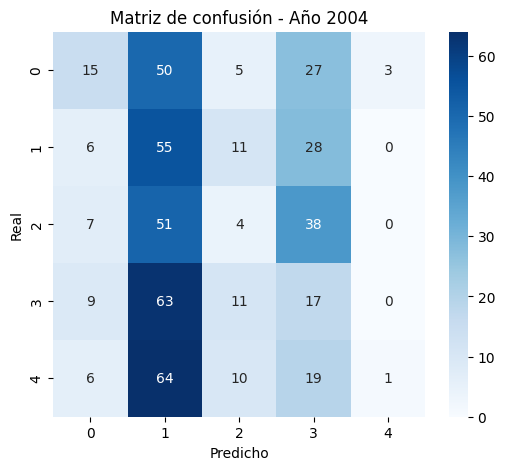

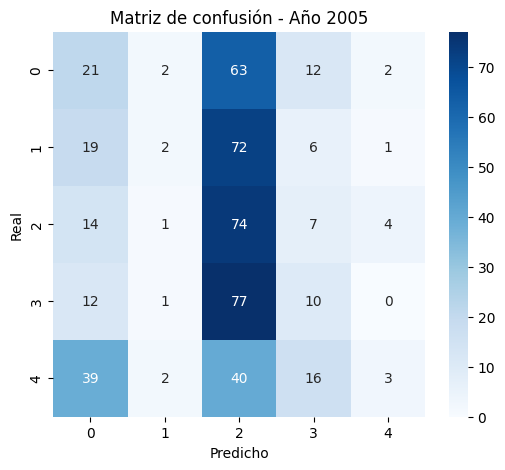

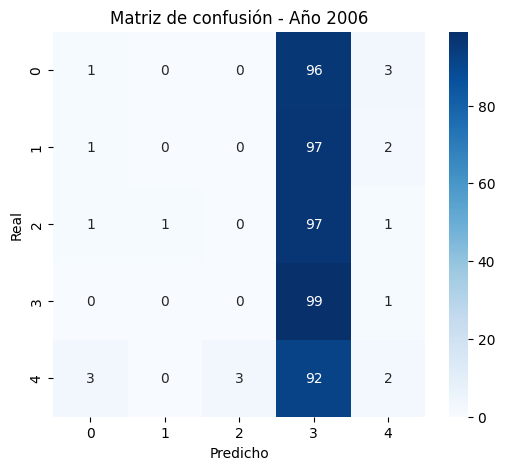

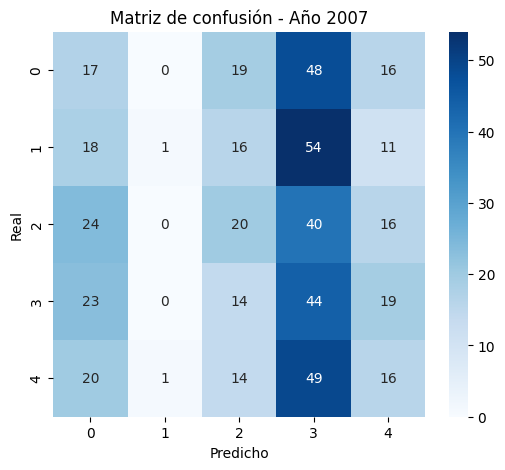

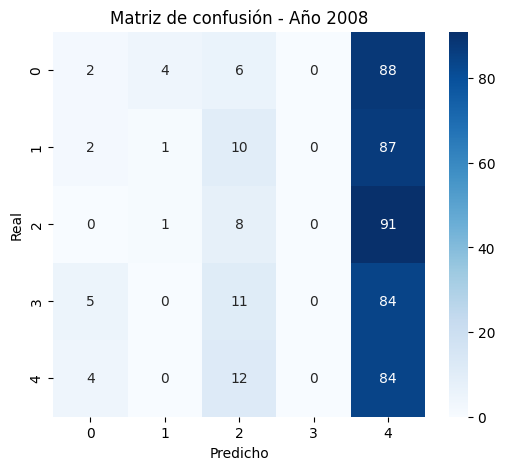

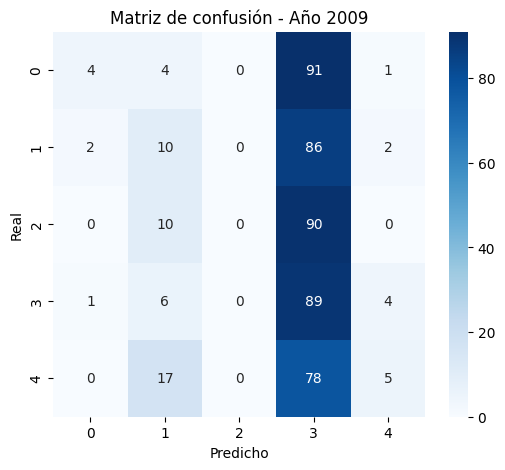

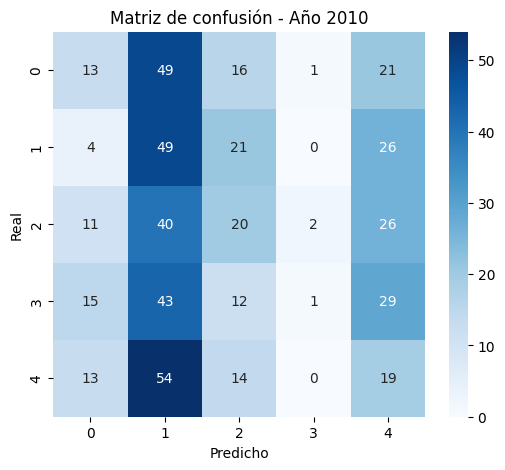

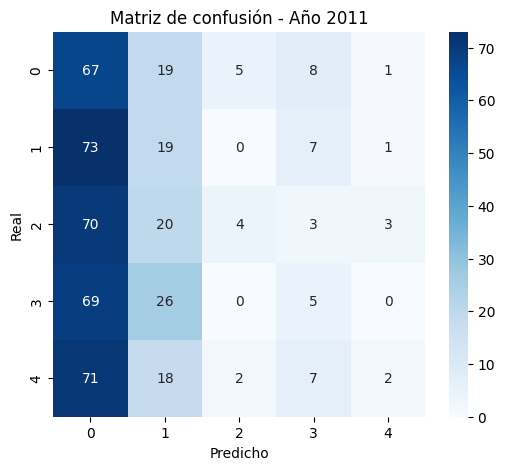

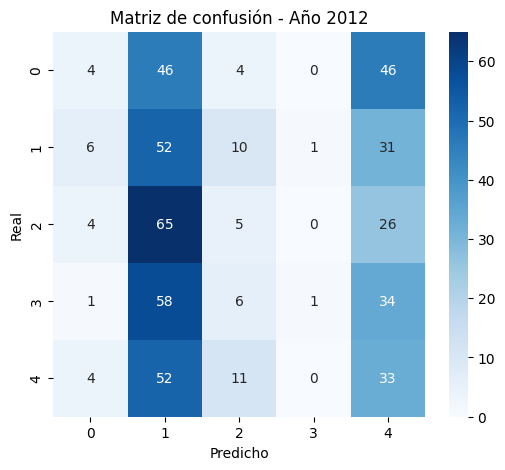

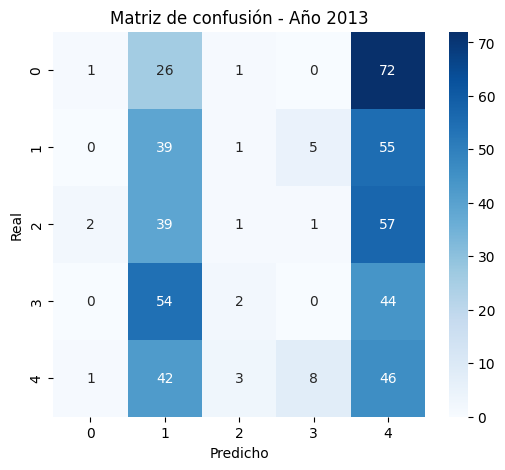

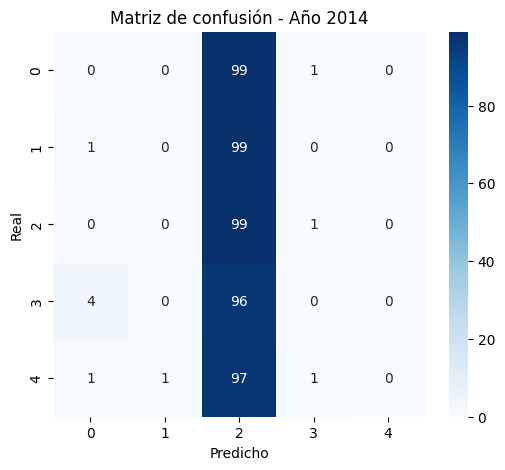

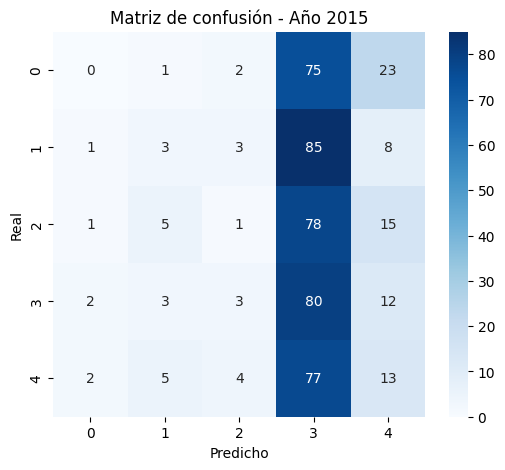

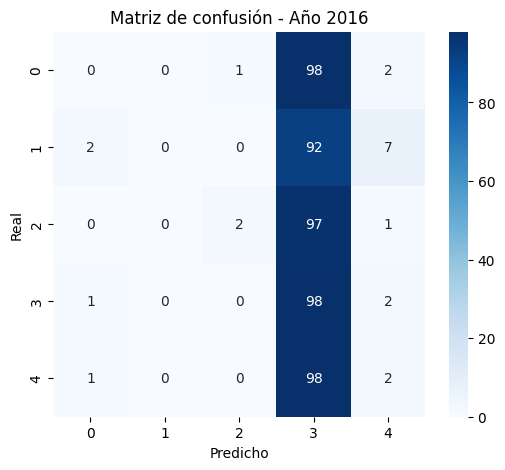

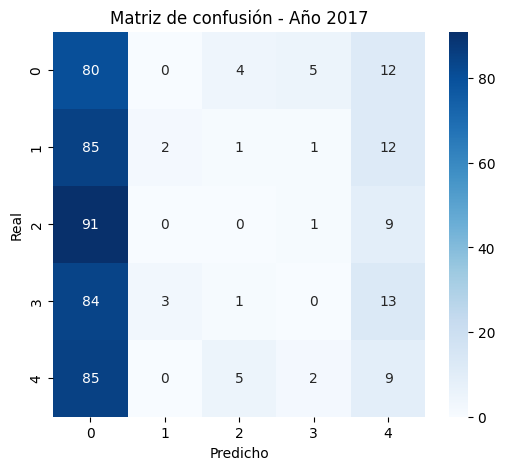

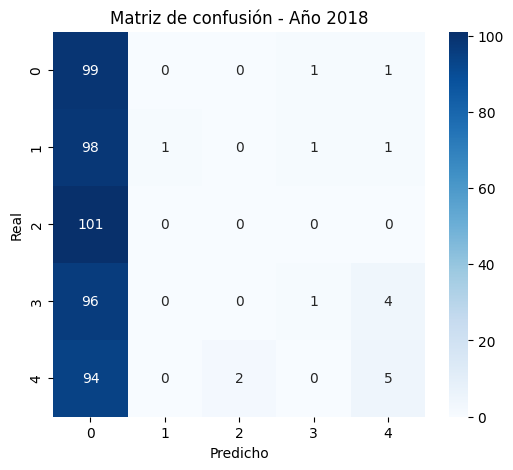

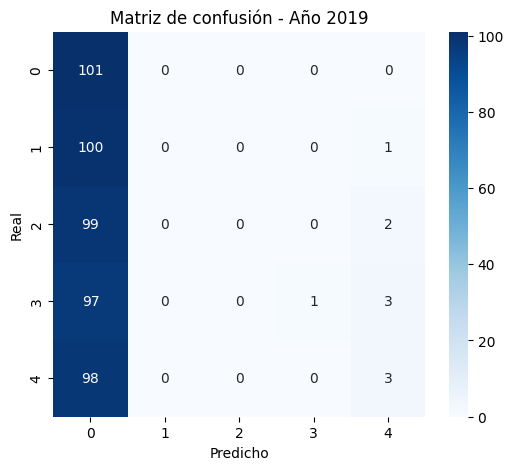

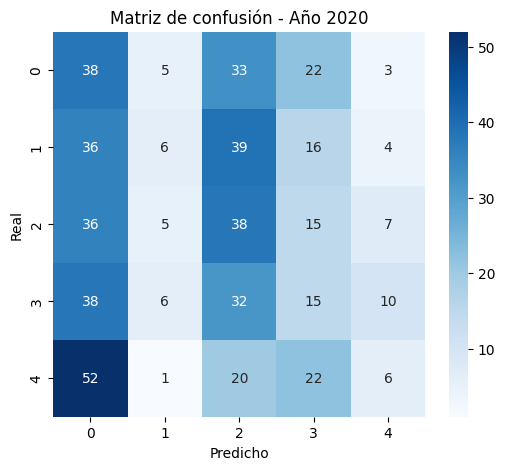

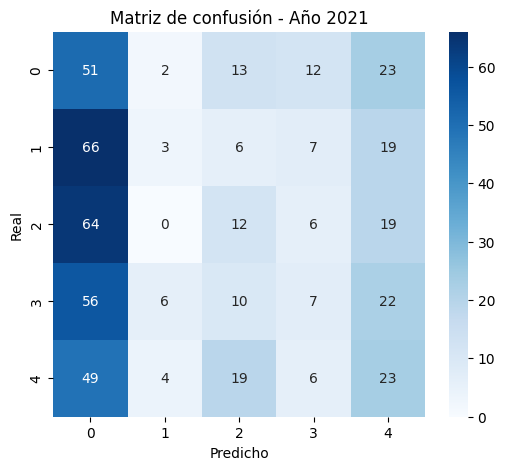

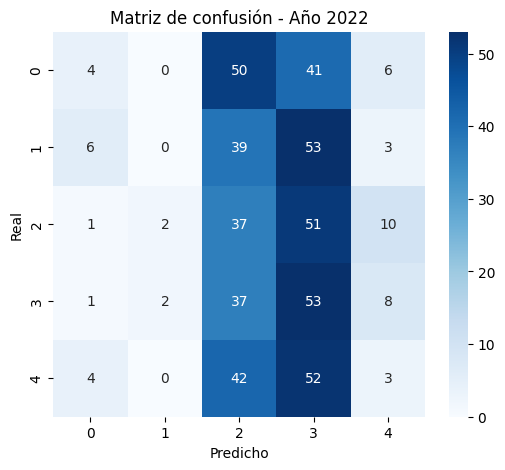

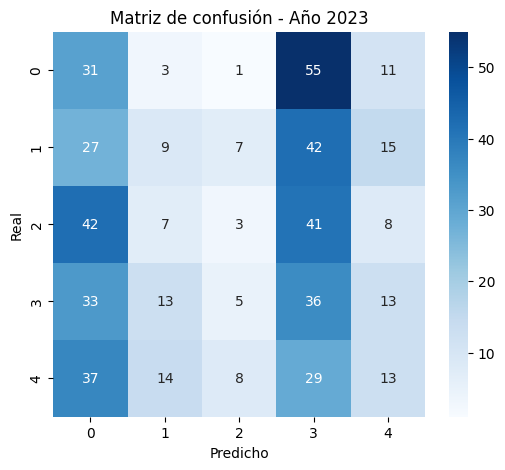

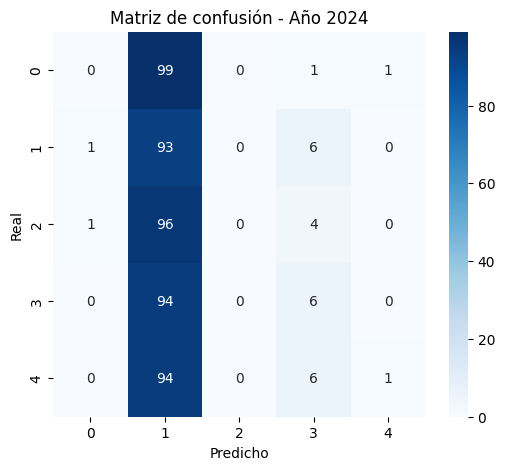

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, row in results_df.iterrows():
    year = row['year']
    conf = np.array(row['confusion_matrix'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.title(f"Matriz de confusión - Año {year}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()


# Red neuronal Binaria, datos normalizados


Enfoque alternativo: convertir en problema de clasificación binaria clases 0-2 vs clases 3-4
Además vamos a normalizar mediante standard scaler

In [82]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

In [64]:
data_normalized.columns

Index(['ticker', 'date', 'vol_1y', 'max_1y', 'min_1y', 'sma_1y', 'sma_2y',
       'volatility_1y', 'revenue', 'eps', 'ebitda', 'netinc', 'roe',
       'evebitda', 'fcfps', 'pb', 'pe', 'marketcap', 'ebit', 'capex', 'ncfo',
       'equity', 'de', 'revenue_yoy', 'ebitda_yoy', 'ebit_yoy', 'eps_yoy',
       'equity_yoy', 'capex_yoy', 'pe_yoy', 'pb_yoy', 'fcfps_yoy', 'ncfo_yoy',
       'closeadj', 'ret_6m', 'ret_12m', 'risk_free_rate', 'target_12m_final',
       'signed_log_revenue', 'signed_log_ebitda', 'signed_log_ebit',
       'signed_log_marketcap', 'signed_log_equity', 'ebit_margin',
       'net_margin', 'capex_to_revenue', 'fcf_yield', 'ps', 'ret_12m_vol',
       'ret_6m_vol', 'sma_diff', 'dist_max_1y', 'dist_min_1y', 'vol_over_sma',
       'cap_category', 'cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap',
       'cap_Small Cap', 'target_class'],
      dtype='object')

In [83]:
data_base.drop(columns=['cap_category', 'closeadj', 'max_1y', 'min_1y', 'marketcap','revenue', 'eps', 'ebitda', 'netinc',
                    'revenue', 'eps', 'ebitda', 'netinc', 'ebit',   ], inplace=True)

In [84]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score

# Copia de la base original
df = data_base.copy()  # Esto funciona si data_base es un DataFrame
df.sort_values(by=['ticker', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Asegurar tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Limpieza de datos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Filtro de años para búsqueda de hiperparámetros (rolling CV)
df_cv = df[(df['date'].dt.year >= 1999) & (df['date'].dt.year <= 2003)]

# Features y target
features = [col for col in df.columns if col not in ['target_class', 'date', 'ticker', 'target_12m_final']]
target = 'target_class'

# Crear folds por año
folds = {year: df_cv[df_cv['date'].dt.year == year] for year in range(1999, 2004)}


In [85]:
# 1 = clase 3 o 4 (acciones "buenas"), 0 = resto

df['target_binary'] = df['target_class'].apply(lambda x: 1 if x >= 3 else 0)


In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from collections import defaultdict
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

#Fijar seed para reproducibilidad
set_seed(42)

n_years = 4
results_bin = []
selected_bin = defaultdict(list)

for test_year in range(2004, 2025):
    train_start = test_year - n_years
    train_end = test_year - 1

    train_df = df[(df['date'].dt.year >= train_start) & (df['date'].dt.year <= train_end)]
    test_df = df[df['date'].dt.year == test_year]

    if train_df.empty or test_df.empty:
        continue

    X_train = train_df[features].copy()
    X_test = test_df[features].copy()

    # Normalización por año, excluyendo variables categóricas
    cols_to_norm = [col for col in features if col not in ['cap_Large Cap', 'cap_Mega Cap', 'cap_Mid Cap', 'cap_Small Cap']]
    scaler = StandardScaler()
    X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
    X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

    y_train = train_df['target_binary'].values
    y_test = test_df['target_binary'].values

    # Red neuronal binaria
    model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # binaria
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.fit(X_train.values.astype('float32'), y_train, epochs=20, batch_size=64, verbose=0)

    y_proba = model.predict(X_test.values.astype('float32'), verbose=0).flatten()
    y_pred = (y_proba >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    # Top 20 por probabilidad
    test_df = test_df.copy()
    test_df['proba_binary'] = y_proba
    top20 = test_df.sort_values('proba_binary', ascending=False).head(20)

    mean_return = top20['target_12m_final'].mean()
    volatility = top20['target_12m_final'].std()

    results_bin.append({
        'year': test_year,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'mean_return_top20': mean_return,
        'volatility_top20': volatility,
        'n_positive_real': y_test.sum(),
        'confusion_matrix': conf_mat.tolist()
    })

    for _, row in top20.iterrows():
        selected_bin[test_year].append({
            'ticker': row['ticker'],
            'ret_12m': row['target_12m_final'],
            'proba_binary': row['proba_binary']
        })


In [87]:
# Guardar resultados y calcular retorno acumulado
results_bin_df = pd.DataFrame(results_bin)
results_bin_df['cumulative_return'] = (1 + results_bin_df['mean_return_top20']).cumprod()

print("📊 Resultados binarios por año:")
display(results_bin_df[[
    'year', 'accuracy', 'precision', 'recall', 
    'mean_return_top20', 'volatility_top20', 
    'n_positive_real', 'cumulative_return'
]])


📊 Resultados binarios por año:


,year,accuracy,precision,recall,mean_return_top20,volatility_top20,n_positive_real,cumulative_return
0,2004,0.606000,0.512195,0.315000,0.153703,0.235401,200,1.153703
1,2005,0.546000,0.423729,0.375000,0.303328,0.347074,200,1.503653
2,2006,0.522000,0.413333,0.465000,0.111292,0.185980,200,1.670997
3,2007,0.578000,0.420290,0.145000,-0.145374,0.288947,200,1.428078
4,2008,0.548000,0.395161,0.245000,-0.546778,0.215254,200,0.647236
5,2009,0.552000,0.200000,0.040000,0.685863,0.678492,200,1.091152
6,2010,0.589178,0.432432,0.080000,0.204418,0.313106,200,1.314203
7,2011,0.626000,0.606557,0.185000,0.128384,0.195367,200,1.482926
8,2012,0.596000,0.000000,0.000000,0.117591,0.364706,200,1.657305
9,2013,0.496000,0.396000,0.495000,0.166944,0.220504,200,1.933982


In [73]:
empresas_bin_df = []
for year, companies in selected_bin.items():
    for entry in companies:
        entry['year'] = year
        empresas_bin_df.append(entry)

empresas_bin_df = pd.DataFrame(empresas_bin_df)


Nota: Probar hacer modelo que compre solo clase 4 pero habiendo normalizado y sin ser binario